In [1]:
import pandas as pd
import os

# IMPORT ALL .CSV
provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Khon Kaen','Songkhla']
data = dict()
subset = 'Train'

for province in provinces:
    df =  pd.read_csv(f'./extracted/{subset}/{province}_full.csv', index_col='Datetime')
    idx = pd.MultiIndex.from_product([[province],['Temp','WindDir','Wind Speed','PM2.5']])
    df.columns = idx
    data[province] = df



In [2]:
grand_data = data['Bangkok']\
                .merge(data['Chanthaburi'], how='left', left_index=True, right_index=True)\
                .merge(data['Chiang Mai'], how='left', left_index=True, right_index=True)\
                .merge(data['Kanchanaburi'], how='left', left_index=True, right_index=True)\
                .merge(data['Khon Kaen'], how='left', left_index=True, right_index=True)\
                .merge(data['Songkhla'], how='left', left_index=True, right_index=True)
grand_data.head()

Bangkok                               Chanthaburi          \
                       Temp WindDir Wind Speed      PM2.5        Temp WindDir   
Datetime                                                                        
2016-03-03 07:00:00    26.4      65         15  62.900000        25.4      70   
2016-03-03 10:00:00    31.4      75         13  52.966667        30.9      75   
2016-03-03 13:00:00    34.1      70         12  35.266667        33.4      65   
2016-03-03 16:00:00    34.6      60         12  33.050000        31.7      55   
2016-03-03 19:00:00    29.1      70         11  42.066667        27.2      65   

                                     Chiang Mai          ... Kanchanaburi  \
                    Wind Speed PM2.5       Temp WindDir  ...   Wind Speed   
Datetime                                                 ...                
2016-03-03 07:00:00         20  44.2       19.9     210  ...           18   
2016-03-03 10:00:00         16  40.9       29.8     205  ...           17   
2016-03-03 13:00:00         11  32.4       33.7     240  ...           13   
2016-03-03 16:00:00         10  37.8       33.4     230  ...           10   
2016-03-03 19:00:00         17  47.2       24.4     220  ...           13   

                               Khon Kaen                                \
                         PM2.5      Temp WindDir Wind Speed      PM2.5   
Datetime                                                                 
2016-03-03 07:00:00  65.200000      20.9      75          8  35.800000   
2016-03-03 10:00:00  56.066667      27.0      85          8  35.950000   
2016-03-03 13:00:00  33.800000      31.2      90         10        NaN   
2016-03-03 16:00:00  48.050000      33.0      80          6  48.700000   
2016-03-03 19:00:00  74.166667      28.1     125          8  60.066667   

                    Songkhla                                
                        Temp WindDir Wind Speed      PM2.5  
Datetime                                                    
2016-03-03 07:00:00     25.4    80.0       38.0  31.200000  
2016-03-03 10:00:00     28.6    85.0       40.0  28.966667  
2016-03-03 13:00:00     30.3    90.0       32.0  23.800000  
2016-03-03 16:00:00     29.3    95.0       31.0  23.200000  
2016-03-03 19:00:00     26.7    85.0       29.0  26.366667  

[5 rows x 24 columns]

In [3]:
if not os.path.exists('pivot_.csv'):    
    grand_data.stack(0, dropna=False).to_csv('pivot_.csv')
    print('Create new file')

Create new file


# ลองสร้างโมเดลของกรุงเทพ


## Train test split

In [5]:
bkk = data['Bangkok'].copy()
bkk.columns = bkk.columns.levels[1]
bkk.drop(['WindDir'], axis=1, inplace=True)
bkk.head()

,PM2.5,Temp,Wind Speed
Datetime,,,
2016-03-03 07:00:00,26.4,65,15
2016-03-03 10:00:00,31.4,75,13
2016-03-03 13:00:00,34.1,70,12
2016-03-03 16:00:00,34.6,60,12
2016-03-03 19:00:00,29.1,70,11


In [6]:
bkk.shape

(8878, 3)

In [7]:
bkk.isnull().sum()

PM2.5         0
Temp          0
Wind Speed    0
dtype: int64

In [8]:
from sklearn.preprocessing import MinMaxScaler

train_size = 8500

train = bkk[['PM2.5']][:train_size]
test = bkk[['PM2.5']][train_size:]

scaler = MinMaxScaler().fit(train.values)

train_scaled = scaler.transform(train.values)
test_scaled = scaler.transform(test.values)

In [37]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# define generator
n_input = 2921
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=100)

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [54]:
model.fit(generator,epochs=5, batch_size=100)

Epoch 1/5
56/56 [==============================] - 1543s 28s/step - loss: 0.1501 - mse: 0.1501
Epoch 2/5
56/56 [==============================] - 1796s 32s/step - loss: 0.0111 - mse: 0.0111
Epoch 3/5
56/56 [==============================] - 1826s 33s/step - loss: 0.0120 - mse: 0.0120
Epoch 4/5
56/56 [==============================] - 1817s 32s/step - loss: 0.0116 - mse: 0.0116
Epoch 5/5
56/56 [==============================] - 2001s 36s/step - loss: 0.0116 - mse: 0.0116


In [56]:
model.save("first_draft.h5")

## Predict

In [10]:
import tensorflow as tf
model = tf.keras.models.load_model('first_draft.h5')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [128]:
data_1 = train_scaled[-n_input:].reshape((1, n_input, n_features))
model.predict(data_1)

array([[0.57502174]], dtype=float32)

In [14]:
n_input = 2921
n_features = 1
import numpy as np

In [15]:
pred = []

for i in range(test.shape[0]):
    left = train_scaled[-(n_input-i):].ravel()
    right = pred[:i]

    to_be_preded = np.r_[left,right].reshape((1, n_input, n_features))

    pred.append(model.predict(to_be_preded)[0][0])
    
    if i%100==0:
        print(f'iteration: {i}')

iteration: 0
iteration: 100
iteration: 200
iteration: 300


In [16]:
pred_scaled = []

for i in pred:
    pred_scaled.append(scaler.inverse_transform([[i]]))

In [17]:
predd = np.array(pred_scaled).reshape(-1,1)

In [18]:
from sklearn.metrics import mean_squared_error as mse

In [19]:
np.sqrt(mse(test, predd))

2.404322466166042

In [118]:
import pandas as pd

df = pd.DataFrame(
    {'pred':predd.ravel(),
    'test':test.values.ravel()}
)

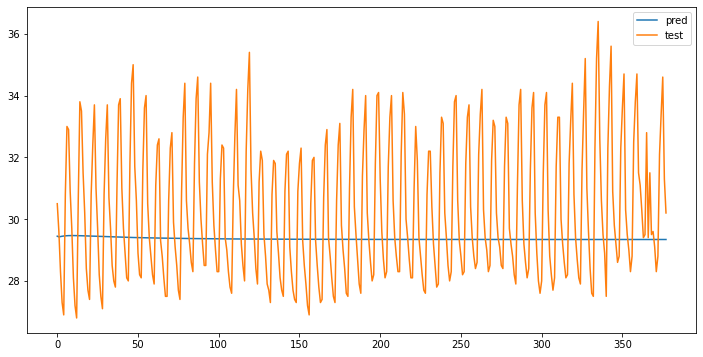

In [123]:
df.plot(figsize=(12,6));

In [21]:
predd.ravel().mean()

29.361494599921357

In [22]:
import pandas as pd

df = pd.DataFrame({'Id': list(range(1, 628129)), 'Expected': predd.ravel().mean()})
df.to_csv('1st_submission.csv', index=False)